In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Сделаем аугментацию нашего датасета, посредством добавления к нашему изначальному датасету его "перевернутый" вариант, с отраженными картинками из изначального датасета

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize
from torchvision.transforms.v2 import RandomHorizontalFlip

fashion_transformer = Compose([
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

fashion_transformer_flip = Compose([
    RandomHorizontalFlip(1.0),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

fashion = FashionMNIST(root="fashion", download=True, train=True, transform=fashion_transformer)
fashion_flip = FashionMNIST(root="fashion", download=True, train=True, transform=fashion_transformer_flip)
fashion_big = fashion + fashion_flip


fashion_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100%|██████████| 26421880/26421880 [00:02<00:00, 12692910.68it/s]


Extracting fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203654.22it/s]


Extracting fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3742302.36it/s]


Extracting fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20255419.32it/s]

Extracting fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion/FashionMNIST/raw



In [ ]:
from torch.utils.data import random_split

train_set, valid_set = random_split(fashion_big, (0.95, 0.05))

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
model = nn.Sequential(

    nn.Conv2d(3, 32, 3),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0.25),

    nn.Conv2d(64, 128, 3),
    nn.ReLU(),
    nn.BatchNorm2d(128),

    nn.Flatten(-3),
    nn.Linear(128 * 10 * 10, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),

    nn.Linear(256, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.5),

    nn.Linear(64, 10),
    nn.LogSoftmax(1)
).to(device)

summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             896
              ReLU-2           [-1, 32, 26, 26]               0
       BatchNorm2d-3           [-1, 32, 26, 26]              64
         Dropout2d-4           [-1, 32, 26, 26]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
              ReLU-6           [-1, 64, 24, 24]               0
         MaxPool2d-7           [-1, 64, 12, 12]               0
         Dropout2d-8           [-1, 64, 12, 12]               0
            Conv2d-9          [-1, 128, 10, 10]          73,856
             ReLU-10          [-1, 128, 10, 10]               0
      BatchNorm2d-11          [-1, 128, 10, 10]             256
          Flatten-12                [-1, 12800]               0
           Linear-13                  [-1, 256]       3,277,056
             ReLU-14                  [

In [ ]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 5.0 MB/s eta 0:00:00


In [ ]:
from ignite.engine import Events

def compute_epoch_results(engine):
    print(f'Epoch[{engine.state.epoch}]')
    train_evaluator.run(train_loader)
    valid_evaluator.run(valid_loader)

def log_train_results(engine, label=""):
    metrics_val = engine.state.metrics
    train_history['accuracy'].append(metrics_val['accuracy'] * 100)
    train_history['precision'].append(metrics_val['precision'] * 100)
    train_history['recall'].append(metrics_val['recall'] * 100)
    train_history['loss'].append(metrics_val['loss'])
    result = ', '.join([f"{m} = {v * 100}" if m != 'loss' else f"{m} = {v}" for m, v in metrics_val.items()])
    print(f"{label} Result:", result)


def log_valid_results(engine, label=""):
    metrics_val = engine.state.metrics
    valid_history['accuracy'].append(metrics_val['accuracy'] * 100)
    valid_history['precision'].append(metrics_val['precision'] * 100)
    valid_history['recall'].append(metrics_val['recall'] * 100)
    valid_history['loss'].append(metrics_val['loss'])
    result = ', '.join([f"{m} = {v * 100}" if m != 'loss' else f"{m} = {v}" for m, v in metrics_val.items()])
    print(f"{label} Result:", result)

In [ ]:
def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}\n")

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def show_charts():
    clear_output()
    plt.figure(figsize=(15,10))

    metric_keys = ['loss', 'accuracy', 'precision', 'recall']
    for idx, metric in enumerate(metric_keys):
      metric_big = metric.capitalize()

      plt.subplot(2, 2, idx + 1)
      plt.plot(train_history[metric],label=f"Training {metric_big}", c='b')
      plt.plot(valid_history[metric],label=f"Validation {metric_big}", c='r')
      plt.xlabel('Epochs')
      plt.ylabel(metric_big)
      plt.legend()

    plt.show()

def show_valid_metrics():
    metric_keys = ['loss', 'accuracy', 'precision', 'recall']
    for metric in metric_keys:
       print(f"Valid {metric.capitalize()}: {valid_history[metric][-1]}")

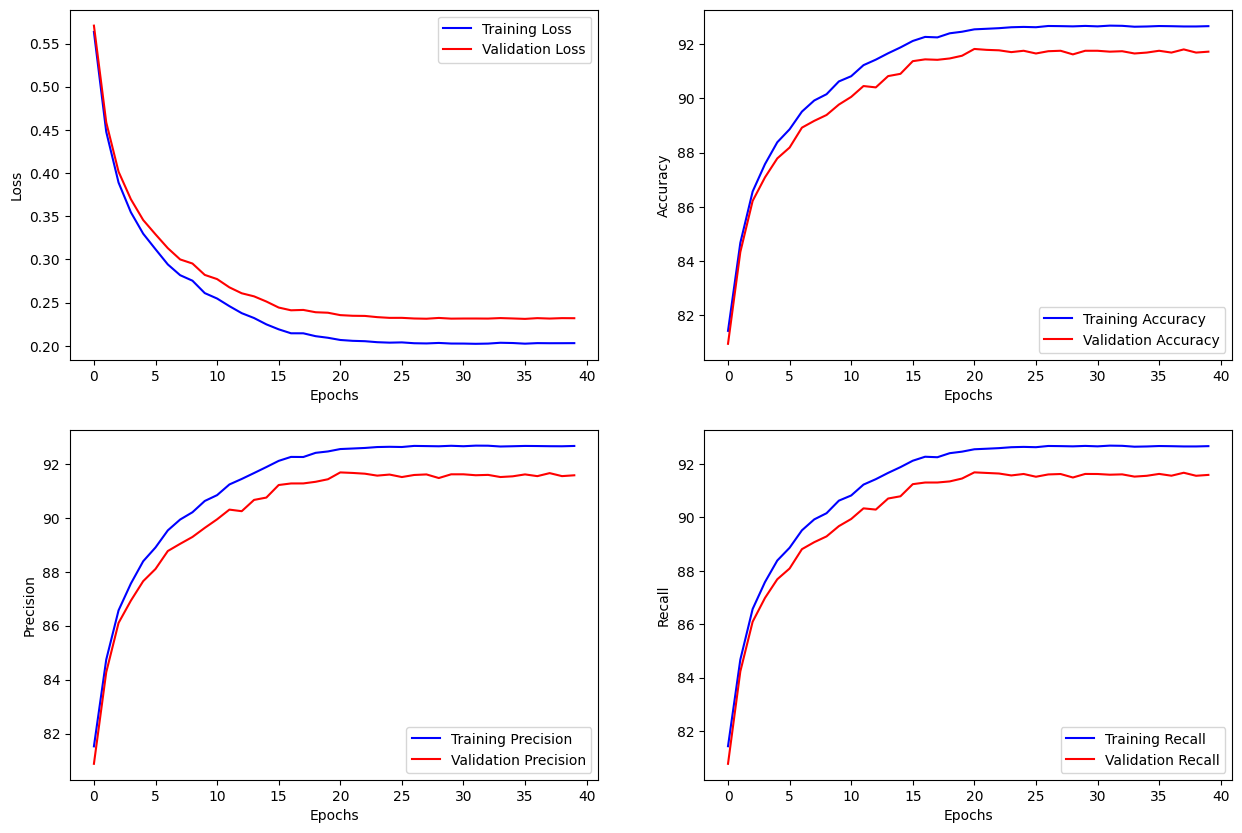

In [10]:
from torch.utils.data import DataLoader
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Precision, Recall, Loss
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=64)
valid_loader = DataLoader(valid_set, batch_size=64)

metrics = {
    "accuracy": Accuracy(),
    "precision": Precision(average=True),
    "recall": Recall(average=True),
    "loss": Loss(criterion)
}

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

trainer = create_supervised_trainer(model, optimizer, criterion, device)

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_train_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_valid_results, label="Valid")

valid_evaluator.add_event_handler(Events.COMPLETED, scheduler)
valid_evaluator.add_event_handler(Events.COMPLETED, print_lr)


train_history = {'accuracy': [], 'precision': [], 'recall': [], 'loss': []}
valid_history = {'accuracy': [], 'precision': [], 'recall': [], 'loss': []}
trainer.run(train_loader, 40)
show_charts()

In [14]:
show_valid_metrics()

Valid Loss: 0.23194500732421874
Valid Accuracy: 91.71666666666667
Valid Precision: 91.5786583472554
Valid Recall: 91.58637245717367


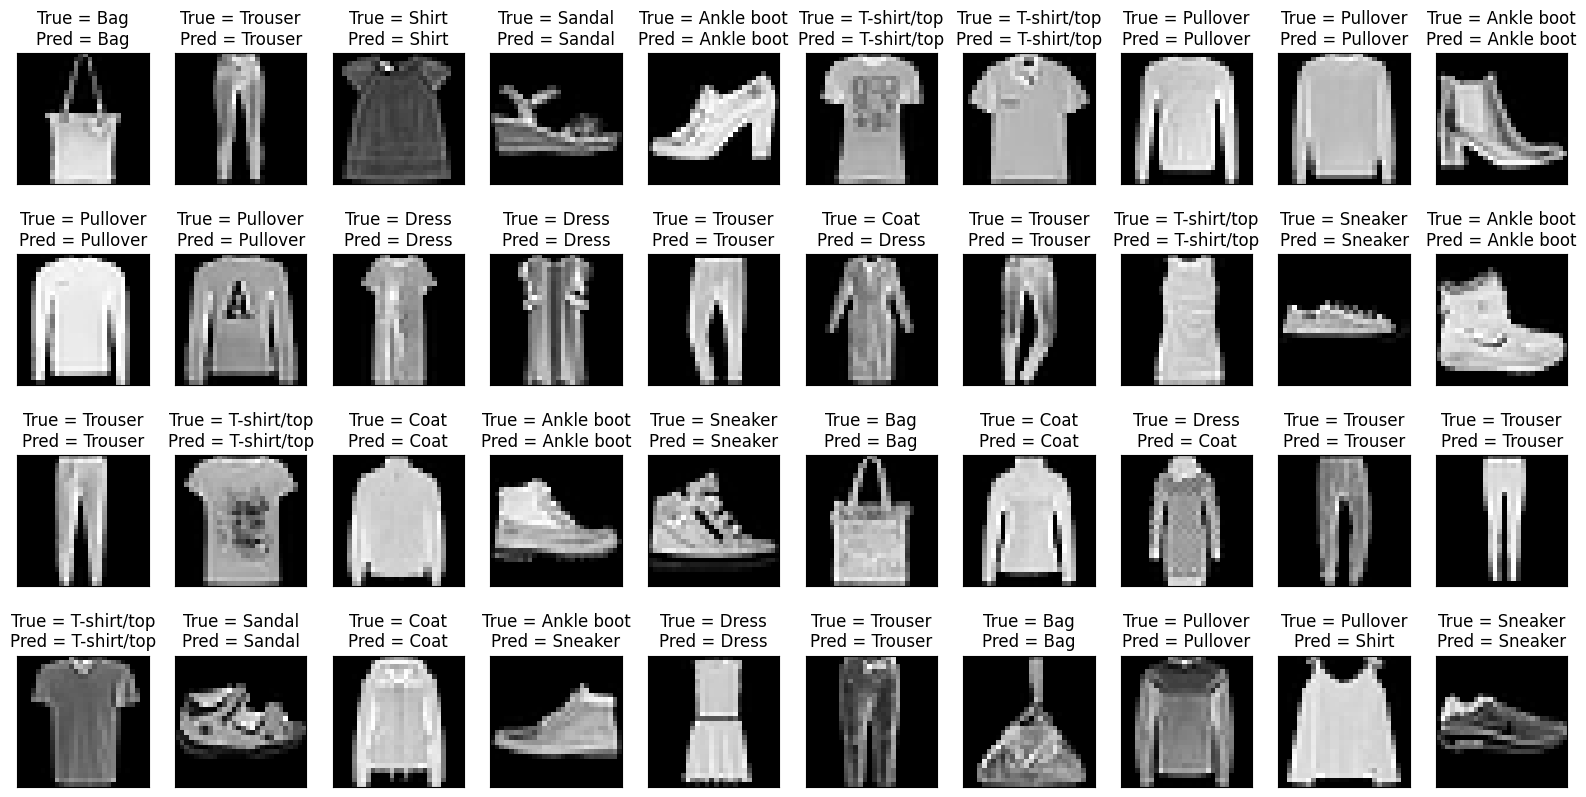

In [16]:
model.eval()

plt.figure(figsize=(20,10))

for i in range(40):
    x, y_true = valid_set[i]
    y_pred = torch.argmax(model(x.unsqueeze(0).to(device)))
    plt.subplot(4, 10, i + 1)
    plt.imshow(x.permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'True = {fashion_names[y_true]}\nPred = {fashion_names[y_pred]}')

plt.show()

#### Вывод
На новом датасете улучшились результаты, модель лучше обучилась за то же количество, что и в прошлой задаче loss = 0.23194500732421874, accuracy = 91.71666666666667. Лосс уменьшился, accuracy увеличился